In [77]:
import tushare as ts
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import talib
from keras.callbacks import TensorBoard
from sklearn.preprocessing import MinMaxScaler
ts.set_token('457a66c9299e50e9e0b2bf6c2f122bb24d560735f01b443158d1c85e') # 日线接口
pro = ts.pro_api()
# df = pro.daily(ts_code='000001.SH', start_date='20100701', end_date='20190923')
df = ts.pro_bar(ts_code='000300.SH', asset='I', start_date='20100701', end_date='20191201')



In [78]:
df['trade_date'] = pd.to_datetime(df['trade_date'])
# df.set_index('trade_date', inplace=True)
df=df.sort_values(by='trade_date')
df=df.reset_index(drop=True) #重置索引
print(df.shape)
#降序


(2291, 11)


In [79]:
df['RSI'] = talib.RSI(df['close'].values, timeperiod = 9)
df['WILLR']= talib.WILLR(df['high'].values, df['low'].values, df['close'].values, 7)
df1=df.dropna()
df1 = df1.drop(['trade_date','ts_code','pre_close','change','pct_chg','vol'],axis=1) #删除
print(df1.shape)

(2282, 7)


In [80]:

train_test_split = int(df1.shape[0]*0.8)
df1=df1.values
print(df1.shape)
# df1_close=df1[:,0]
# df1=np.delete(df1,0,axis=1)
scaler = MinMaxScaler(feature_range=(0, 1)) #不能使用一维的数据
# scaler1_close = MinMaxScaler(feature_range=(0, 1))
df1=scaler.fit_transform(df1)
# df1_close=scaler.fit_transform(df1_close)
# x_train=scaler.fit_transform(x_train)
# x_test=scaler.fit_transform(x_test)
# y_train=scaler.fit_transform(y_train)
# y_test==scaler.fit_transform(y_test)

(2282, 7)


In [81]:
x_pre_train=df1[:train_test_split,:]
x_pre_test=df1[train_test_split:,:]

In [82]:
def create_dataset(dataset, look_back=7, foresight=3):   
    X, Y = [], []
    for i in range(len(dataset)-look_back-foresight): 
        obs = dataset[i:(i+look_back),:] # Sequence of 7 stock prices as features forming an observation                                        
       # Append sequence
        X.append(obs)
       # Append stock price value occurring 4 time-steps into future
        Y.append(dataset[i + (look_back+foresight), 0]) 
    return np.array(X), np.array(Y)

In [83]:
x_train, y_train = create_dataset(x_pre_train)
x_test, y_test = create_dataset(x_pre_test)
print(x_train.shape,y_train.shape)
x_train

(1815, 7, 7) (1815,)


array([[[0.17345561, 0.17003703, 0.1734792 , ..., 0.03048232,
         0.73766734, 0.80629074],
        [0.15965304, 0.17288858, 0.17219947, ..., 0.02180795,
         0.59880627, 0.42449558],
        [0.16198224, 0.1567248 , 0.15407667, ..., 0.01532039,
         0.61180753, 0.44412674],
        ...,
        [0.20036097, 0.18353382, 0.19237186, ..., 0.06437351,
         0.76802052, 0.97254745],
        [0.20214621, 0.2014866 , 0.19849395, ..., 0.05659203,
         0.77339046, 0.90192868],
        [0.212539  , 0.19946545, 0.20368551, ..., 0.04564933,
         0.80384222, 0.99115332]],

       [[0.15965304, 0.17288858, 0.17219947, ..., 0.02180795,
         0.59880627, 0.42449558],
        [0.16198224, 0.1567248 , 0.15407667, ..., 0.01532039,
         0.61180753, 0.44412674],
        [0.1822909 , 0.15523583, 0.17572378, ..., 0.04160916,
         0.70755083, 0.92972126],
        ...,
        [0.20214621, 0.2014866 , 0.19849395, ..., 0.05659203,
         0.77339046, 0.90192868],
        [0.2

In [84]:
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from keras.layers import Dropout, Flatten
from keras.layers.embeddings import Embedding

from keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('训练历史')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['训练集','验证集'], loc='upper right')
    plt.show()
# print(x_train.shape)
# x_train=x_train.reshape(x_train.shape[0],-1)
# x_test=x_test.reshape(x_test.shape[0],-1)
# print(x_train.shape)

In [85]:
# model = Sequential()
# model.add(Flatten())
# model.add(Dense(units=128, activation='sigmoid'))
# model.add(Dropout(0.25))
# model.add(Dense(units=128, activation='sigmoid'))
# model.add(Dropout(0.25))
# model.add(Dense(units=1,  activation='sigmoid'))
# model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])
# train_history = model.fit(x_train, y_train, validation_split=0.2, epochs=30, batch_size=100,  verbose=2)



In [ ]:
# min_epoch=train_history.history['loss'].index(min(train_history.history['loss'])) #求最小的epoch在哪个位置
# print("最小的训练轮数是第",min_epoch,"\n最小的训练MSE为",min(train_history.history['loss']))
# print(model.summary())
# show_train_history(train_history,'loss','val_loss')
# scores = model.evaluate(x_test, y_test, verbose =1)
# print("测试集数据MSE为",scores[1])

In [86]:
model1 = Sequential()
model1.add(LSTM(64,  input_shape=(7, 7), dropout=0.1, recurrent_dropout=0.1))
model1.add(Dense(units=256, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='mse', optimizer='adam', metrics = ['mse']) 
train_history1 = model1.fit(x_train, y_train, validation_split=0.2, epochs=30, batch_size=128,  verbose=1)

Train on 1452 samples, validate on 363 samples
Epoch 1/30
1452/1452 [==============================] - 2s 1ms/step - loss: 0.0757 - mean_squared_error: 0.0757 - val_loss: 0.0438 - val_mean_squared_error: 0.0438
Epoch 2/30
1452/1452 [==============================] - 0s 87us/step - loss: 0.0371 - mean_squared_error: 0.0371 - val_loss: 0.0162 - val_mean_squared_error: 0.0162
Epoch 3/30
1452/1452 [==============================] - 0s 85us/step - loss: 0.0181 - mean_squared_error: 0.0181 - val_loss: 0.0152 - val_mean_squared_error: 0.0152
Epoch 4/30
1452/1452 [==============================] - 0s 87us/step - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 5/30
1452/1452 [==============================] - 0s 86us/step - loss: 0.0071 - mean_squared_error: 0.0071 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 6/30
1452/1452 [==============================] - 0s 81us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.00

最小的训练轮数是第 26 
最小的训练MSE为 0.0023143658197687595
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 64)                18432     
_________________________________________________________________
dense_7 (Dense)              (None, 256)               16640     
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 257       
Total params: 35,329
Trainable params: 35,329
Non-trainable params: 0
_________________________________________________________________
None
447/447 [==============================] - 0s 52us/step
测试集数据MSE为 0.005147225713103143


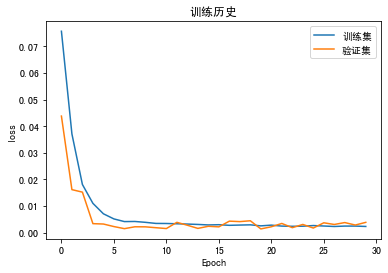

In [87]:
min_epoch=train_history1.history['loss'].index(min(train_history1.history['loss'])) #求最小的epoch在哪个位置
print("最小的训练轮数是第",min_epoch,"\n最小的训练MSE为",min(train_history1.history['loss']))
# min_epoch=np.where(np.array(train_history.history['val_loss'])==np.min(train_history.history['val_loss'],axis=0))#另外一种做法
# list(min_epoch)[0][0]
# print(model.summary())
# show_train_history(train_history,'loss','val_loss')

print(model1.summary())
show_train_history(train_history1,'loss','val_loss')

# scores = model.evaluate(x_test, y_test, verbose =2)
# scores
scores = model1.evaluate(x_test, y_test, verbose =1)
print("测试集数据MSE为",scores[1])


测试集数据MSE为 0.0045516417576395955


In [88]:
# test_predict=model.predict(x_test)
# print(test_predict.shape,test_predict)
test_predict=model1.predict(x_test)
print(test_predict.shape,type(test_predict),test_predict)


(447, 1) <class 'numpy.ndarray'> [[0.63661045]
 [0.65237606]
 [0.66398203]
 [0.6587414 ]
 [0.65910214]
 [0.62870216]
 [0.5928729 ]
 [0.58185005]
 [0.5695473 ]
 [0.56474876]
 [0.56337935]
 [0.54437333]
 [0.5278003 ]
 [0.5075182 ]
 [0.48364425]
 [0.46656993]
 [0.46391836]
 [0.46070886]
 [0.4738315 ]
 [0.49095652]
 [0.5095791 ]
 [0.51136756]
 [0.49838108]
 [0.49776945]
 [0.48139465]
 [0.47368157]
 [0.48798236]
 [0.48461553]
 [0.5014536 ]
 [0.51806206]
 [0.53195995]
 [0.5238384 ]
 [0.51309603]
 [0.5115452 ]
 [0.49519295]
 [0.4924944 ]
 [0.49058717]
 [0.48774487]
 [0.47786877]
 [0.46920317]
 [0.45590675]
 [0.45620728]
 [0.44312358]
 [0.4468363 ]
 [0.4486369 ]
 [0.45738614]
 [0.4506903 ]
 [0.4472137 ]
 [0.44205266]
 [0.46038777]
 [0.4693192 ]
 [0.4599122 ]
 [0.44876024]
 [0.43452346]
 [0.42069405]
 [0.41929662]
 [0.42564678]
 [0.42149872]
 [0.41944247]
 [0.44038683]
 [0.4458348 ]
 [0.43132576]
 [0.4250028 ]
 [0.42265868]
 [0.42705327]
 [0.42311972]
 [0.4438629 ]
 [0.45837945]
 [0.46201885]
 

In [90]:
# test_predict=test_predict[0:440]
x_pre_test=x_pre_test[:-10,1:7]  #x_pre_test=x_pre_test[10:,1:7] ?????
x_pre_test=np.concatenate([test_predict,x_pre_test], axis=1)
test_predict=scaler.inverse_transform(x_pre_test)
print(x_pre_test.shape,test_predict_1line.shape)

(447, 7) (447,)


In [91]:

print(test_predict.shape,test_predict)

(447, 7) [[ 4.16663583e+03  4.20514440e+03  4.22739230e+03 ...  1.57606211e+08
   7.77171810e+01 -1.96804286e+00]
 [ 4.21813866e+03  4.22983570e+03  4.26293140e+03 ...  2.34986586e+08
   7.77466179e+01 -2.69904626e+01]
 [ 4.25605288e+03  4.21562470e+03  4.26021180e+03 ...  2.28271225e+08
   8.15671342e+01 -3.28734074e+00]
 ...
 [ 3.55942537e+03  3.90528310e+03  3.90841960e+03 ...  1.12057146e+08
   4.21812016e+01 -8.54532160e+01]
 [ 3.53554001e+03  3.90592840e+03  3.91694590e+03 ...  1.19791567e+08
   4.40517057e+01 -8.05142190e+01]
 [ 3.54504943e+03  3.90848910e+03  3.91510490e+03 ...  1.15423021e+08
   3.73890369e+01 -1.00000000e+02]]


In [70]:
test_predict_1line=test_predict_3[:,0]